In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from pathlib import Path
from datetime import datetime
import warnings
import os

In [2]:
# Setup
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
np.random.seed(42)

In [4]:
# Paths - Works in both script and Jupyter notebook
from pathlib import Path
import os

# Determine project root based on environment
try:
    # Script mode
    PROJECT_ROOT = Path(__file__).parent.parent
except NameError:
    # Notebook mode - check current directory
    cwd = Path.cwd()
    if cwd.name == 'notebooks':
        PROJECT_ROOT = cwd.parent
    elif (cwd / 'cleaned_data').exists():
        PROJECT_ROOT = cwd
    else:
        PROJECT_ROOT = cwd

DATA_DIR = PROJECT_ROOT / 'cleaned_data'
VIS_DIR = PROJECT_ROOT / 'visualizations'
VIS_DIR.mkdir(exist_ok=True)

print(f"PROJECT_ROOT: {PROJECT_ROOT}")
print(f"DATA_DIR: {DATA_DIR}")
print(f"DATA_DIR exists: {DATA_DIR.exists()}")

In [5]:
# Colors
COLORS = {'bio': '#7B1FA2', 'demo': '#00897B', 'enrol': '#D81B60', 'primary': '#1E88E5'}

In [6]:
print("=" * 70)
print("UIDAI DATA HACKATHON 2026 - AADHAAR DATA ANALYSIS")
print("=" * 70)
print(f"Analysis Date: {datetime.now()}")
print(f"Output Directory: {VIS_DIR}")

UIDAI DATA HACKATHON 2026 - AADHAAR DATA ANALYSIS
Analysis Date: 2026-01-20 19:44:26.497201
Output Directory: D:\Aadhar data hackathon\UIDAI-DATA-Hackathon\visualizations


In [7]:
# 1. DATA LOADING
print("\n[1/10] LOADING DATA...")


[1/10] LOADING DATA...


In [8]:
def load_all_files(folder):
    """Load all CSVs from a folder."""
    path = PROJECT_ROOT / folder / folder
    files = sorted(path.glob('*.csv'))
    dfs = []
    for f in files:
        df = pd.read_csv(f, encoding='utf-8-sig', on_bad_lines='skip')
        dfs.append(df)
        print(f"  Loaded {f.name}: {len(df):,} rows")
    return pd.concat(dfs, ignore_index=True)

In [9]:
df_bio = load_all_files('api_data_aadhar_biometric')
df_demo = load_all_files('api_data_aadhar_demographic')
df_enrol = load_all_files('api_data_aadhar_enrolment')

  Loaded api_data_aadhar_biometric_0_500000.csv: 500,000 rows
  Loaded api_data_aadhar_biometric_1000000_1500000.csv: 500,000 rows
  Loaded api_data_aadhar_biometric_1500000_1861108.csv: 361,108 rows
  Loaded api_data_aadhar_biometric_500000_1000000.csv: 500,000 rows
  Loaded api_data_aadhar_demographic_0_500000.csv: 500,000 rows
  Loaded api_data_aadhar_demographic_1000000_1500000.csv: 500,000 rows
  Loaded api_data_aadhar_demographic_1500000_2000000.csv: 500,000 rows
  Loaded api_data_aadhar_demographic_2000000_2071700.csv: 71,700 rows
  Loaded api_data_aadhar_demographic_500000_1000000.csv: 500,000 rows
  Loaded api_data_aadhar_enrolment_0_500000.csv: 500,000 rows
  Loaded api_data_aadhar_enrolment_1000000_1006029.csv: 6,029 rows
  Loaded api_data_aadhar_enrolment_500000_1000000.csv: 500,000 rows


In [10]:
print(f"\n✓ Biometric: {len(df_bio):,} rows")
print(f"✓ Demographic: {len(df_demo):,} rows")
print(f"✓ Enrolment: {len(df_enrol):,} rows")


✓ Biometric: 1,861,108 rows
✓ Demographic: 2,071,700 rows
✓ Enrolment: 1,006,029 rows


In [11]:
# 2. PREPROCESSING
print("\n[2/10] PREPROCESSING...")


[2/10] PREPROCESSING...


In [12]:
def preprocess(df, name):
    df['date'] = pd.to_datetime(df['date'], format='%d-%m-%Y', errors='coerce')
    df['month'] = df['date'].dt.month
    df['weekday'] = df['date'].dt.dayofweek
    df['day_name'] = df['date'].dt.day_name()
    df['is_weekend'] = df['weekday'].isin([5, 6]).astype(int)
    df['state_clean'] = df['state'].str.strip().str.title()
    
    # Total count per row
    num_cols = df.select_dtypes(include=[np.number]).columns
    age_cols = [c for c in num_cols if 'age' in c.lower() or 'bio' in c.lower() or 'demo' in c.lower()]
    if age_cols:
        df['total_count'] = df[age_cols].sum(axis=1)
    
    df = df.drop_duplicates().dropna(subset=['date'])
    print(f"  {name}: {len(df):,} rows after cleaning")
    return df

In [13]:
df_bio = preprocess(df_bio, "Biometric")
df_demo = preprocess(df_demo, "Demographic")
df_enrol = preprocess(df_enrol, "Enrolment")

  Biometric: 1,766,212 rows after cleaning
  Demographic: 1,598,099 rows after cleaning
  Enrolment: 983,072 rows after cleaning


In [14]:
# 3. STATISTICAL SUMMARY
print("\n[3/10] STATISTICAL SUMMARY...")


[3/10] STATISTICAL SUMMARY...


In [15]:
for name, df in [("Biometric", df_bio), ("Demographic", df_demo), ("Enrolment", df_enrol)]:
    print(f"\n{name} - total_count stats:")
    print(f"  Mean: {df['total_count'].mean():,.1f}")
    print(f"  Median: {df['total_count'].median():,.1f}")
    print(f"  Std: {df['total_count'].std():,.1f}")
    print(f"  Min/Max: {df['total_count'].min():,.0f} / {df['total_count'].max():,.0f}")


Biometric - total_count stats:
  Mean: 38.6
  Median: 8.0
  Std: 166.4
  Min/Max: 0 / 13,381

Demographic - total_count stats:
  Mean: 22.9
  Median: 7.0
  Std: 129.7
  Min/Max: 0 / 16,942

Enrolment - total_count stats:
  Mean: 5.4
  Median: 2.0
  Std: 31.9
  Min/Max: 1 / 3,965


In [16]:
# 4. VISUALIZATION 1: Time Series
print("\n[4/10] CREATING TIME SERIES PLOTS...")


[4/10] CREATING TIME SERIES PLOTS...


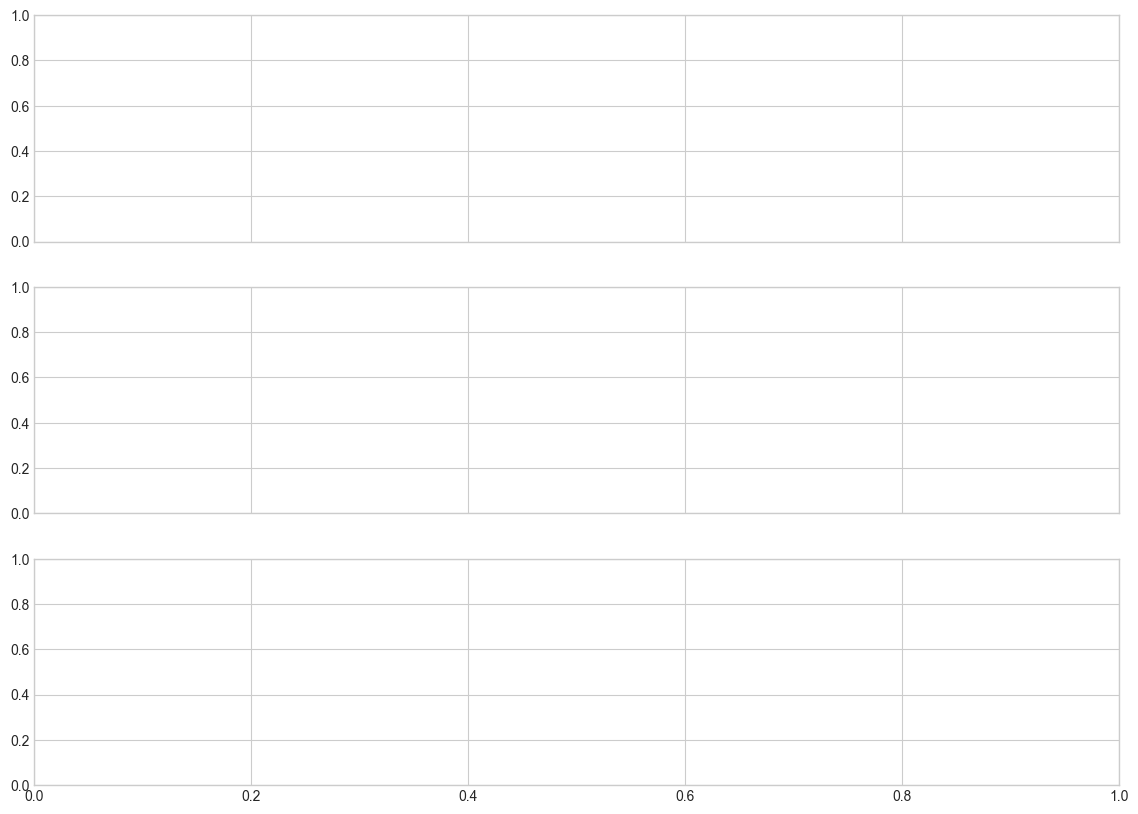

In [17]:
fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

In [18]:
for ax, (name, df, color) in zip(axes, [('Biometric', df_bio, COLORS['bio']), 
                                          ('Demographic', df_demo, COLORS['demo']),
                                          ('Enrolment', df_enrol, COLORS['enrol'])]):
    daily = df.groupby('date')['total_count'].sum()
    ax.fill_between(daily.index, daily.values, alpha=0.4, color=color)
    ax.plot(daily.index, daily.values, color=color, linewidth=1)
    ax.axhline(daily.mean(), color='red', linestyle='--', alpha=0.7, label=f'Mean: {daily.mean():,.0f}')
    ax.set_title(f'Daily {name} Activity', fontweight='bold')
    ax.set_ylabel('Count')
    ax.legend()

In [19]:
plt.xlabel('Date')
plt.suptitle('UIDAI Aadhaar Activity Over Time', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(VIS_DIR / '01_time_series.png', dpi=150, bbox_inches='tight')
plt.close()
print("  ✓ Saved 01_time_series.png")

  ✓ Saved 01_time_series.png


In [20]:
# 5. VISUALIZATION 2: Top States
print("\n[5/10] CREATING STATE DISTRIBUTION...")


[5/10] CREATING STATE DISTRIBUTION...


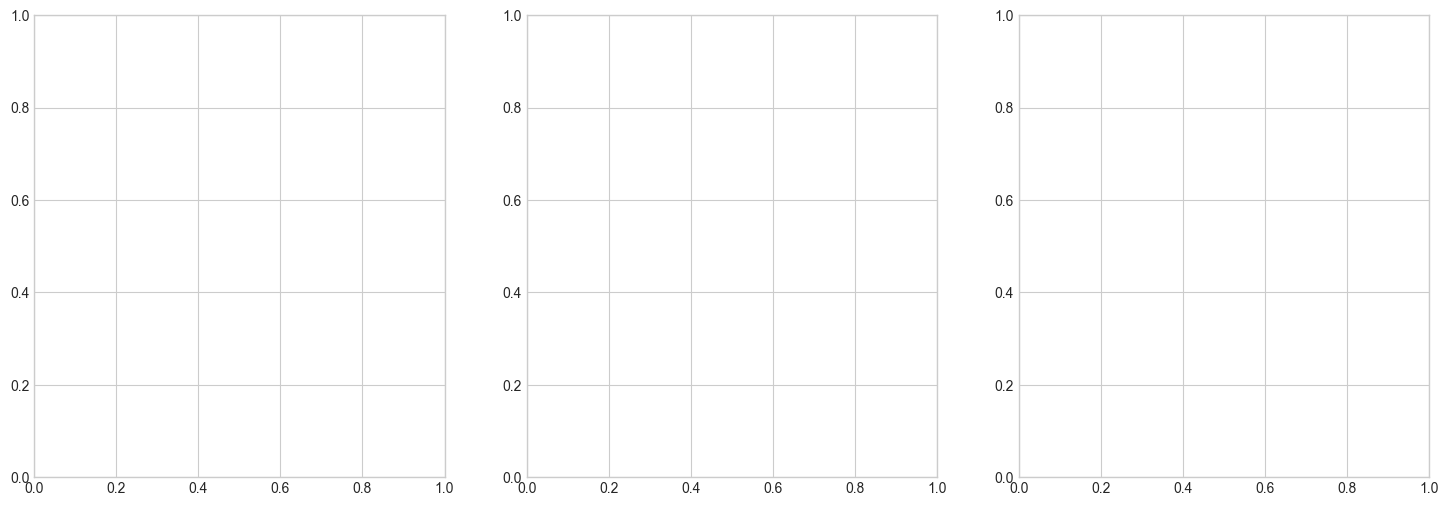

In [21]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

In [22]:
for ax, (name, df, color) in zip(axes, [('Biometric', df_bio, COLORS['bio']),
                                          ('Demographic', df_demo, COLORS['demo']),
                                          ('Enrolment', df_enrol, COLORS['enrol'])]):
    top = df.groupby('state_clean')['total_count'].sum().nlargest(15)
    ax.barh(top.index, top.values / 1e6, color=color, alpha=0.8)
    ax.set_title(f'Top 15 States - {name}', fontweight='bold')
    ax.set_xlabel('Total (Millions)')

In [23]:
plt.suptitle('State-wise Aadhaar Activity', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(VIS_DIR / '02_states.png', dpi=150, bbox_inches='tight')
plt.close()
print("  ✓ Saved 02_states.png")

  ✓ Saved 02_states.png


In [24]:
# 6. VISUALIZATION 3: Day of Week
print("\n[6/10] CREATING DAY OF WEEK ANALYSIS...")


[6/10] CREATING DAY OF WEEK ANALYSIS...


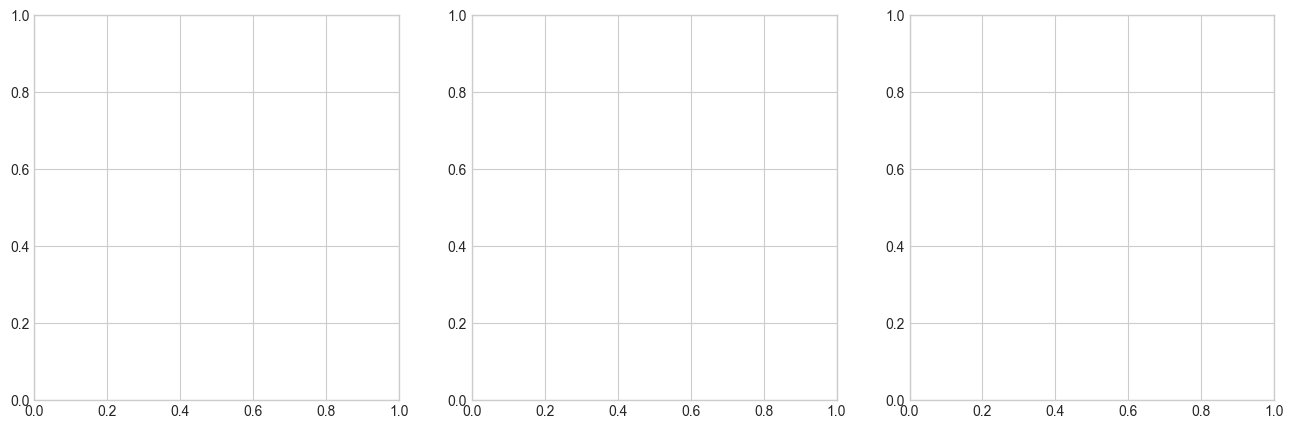

In [25]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

In [ ]:
for ax, (name, df, color) in zip(axes, [('Biometric', df_bio, COLORS['bio']),
                                          ('Demographic', df_demo, COLORS['demo']),
                                          ('Enrolment', df_enrol, COLORS['enrol'])]):
    dow = df.groupby('day_name')['total_count'].mean().reindex(day_order)
    bars = ax.bar(dow.index, dow.values, color=color, alpha=0.8)
    for i, d in enumerate(day_order):
        if d in ['Saturday', 'Sunday']:
            bars[i].set_alpha(0.4)
            bars[i].set_hatch('//')
    ax.set_title(f'{name} by Day', fontweight='bold')
    ax.tick_params(axis='x', rotation=45)

In [ ]:
plt.suptitle('Activity by Day of Week (Weekends Hatched)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(VIS_DIR / '03_weekday.png', dpi=150, bbox_inches='tight')
plt.close()
print("  ✓ Saved 03_weekday.png")

In [ ]:
# 7. VISUALIZATION 4: Age Distribution
print("\n[7/10] CREATING AGE DISTRIBUTION...")

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

In [ ]:
enrol_age = [c for c in df_enrol.columns if 'age' in c.lower() and c != 'total_count']
bio_age = [c for c in df_bio.columns if 'bio_age' in c.lower()]
demo_age = [c for c in df_demo.columns if 'demo_age' in c.lower()]

In [ ]:
for ax, (name, df, cols) in zip(axes, [('Biometric', df_bio, bio_age),
                                         ('Demographic', df_demo, demo_age),
                                         ('Enrolment', df_enrol, enrol_age)]):
    if cols:
        totals = df[cols].sum()
        labels = [c.replace('bio_', '').replace('demo_', '').replace('_', ' ').title() for c in cols]
        ax.pie(totals.values, labels=labels, autopct='%1.1f%%', startangle=90)
        ax.set_title(f'{name} - Age Groups', fontweight='bold')

In [ ]:
plt.suptitle('Age Group Distribution', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(VIS_DIR / '04_age_dist.png', dpi=150, bbox_inches='tight')
plt.close()
print("  ✓ Saved 04_age_dist.png")

In [ ]:
# 8. VISUALIZATION 5: Correlation & Box Plots
print("\n[8/10] CREATING CORRELATION & BOX PLOTS...")

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

In [ ]:
# Box plots (top row)
for ax, (name, df, color) in zip(axes[0], [('Biometric', df_bio, COLORS['bio']),
                                            ('Demographic', df_demo, COLORS['demo']),
                                            ('Enrolment', df_enrol, COLORS['enrol'])]):
    bp = ax.boxplot(df['total_count'].values, patch_artist=True)
    bp['boxes'][0].set_facecolor(color)
    ax.set_title(f'{name} Distribution', fontweight='bold')
    ax.set_ylabel('Count')

In [ ]:
# State comparison (bottom left)
state_comp = pd.DataFrame({
    'Biometric': df_bio.groupby('state_clean')['total_count'].sum(),
    'Demographic': df_demo.groupby('state_clean')['total_count'].sum()
}).dropna()
axes[1,0].scatter(state_comp['Biometric']/1e6, state_comp['Demographic']/1e6, alpha=0.6, c=COLORS['primary'])
axes[1,0].set_xlabel('Biometric (M)')
axes[1,0].set_ylabel('Demographic (M)')
axes[1,0].set_title('State Correlation: Bio vs Demo', fontweight='bold')
corr = state_comp['Biometric'].corr(state_comp['Demographic'])
axes[1,0].text(0.05, 0.95, f'r = {corr:.3f}', transform=axes[1,0].transAxes, fontsize=12, va='top')

In [ ]:
# Weekday heatmap (bottom middle)
pivot = df_bio.pivot_table(values='total_count', index='weekday', 
                            columns=df_bio['date'].dt.to_period('W'), aggfunc='sum')
if not pivot.empty:
    sns.heatmap(pivot.iloc[:, :10], cmap='Purples', ax=axes[1,1], cbar_kws={'label': 'Count'})
    axes[1,1].set_title('Biometric Weekly Heatmap', fontweight='bold')
    axes[1,1].set_yticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])

In [ ]:
# Monthly trend (bottom right)
monthly = df_enrol.groupby(df_enrol['date'].dt.to_period('M'))['total_count'].sum()
axes[1,2].bar(range(len(monthly)), monthly.values/1e6, color=COLORS['enrol'])
axes[1,2].set_title('Monthly Enrolments', fontweight='bold')
axes[1,2].set_xlabel('Month')
axes[1,2].set_ylabel('Total (M)')

In [ ]:
plt.tight_layout()
plt.savefig(VIS_DIR / '05_analysis_grid.png', dpi=150, bbox_inches='tight')
plt.close()
print("  ✓ Saved 05_analysis_grid.png")

In [ ]:
# 9. ANOMALY DETECTION
print("\n[9/10] ANOMALY DETECTION...")

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

In [ ]:
for ax, (name, df, color) in zip(axes, [('Biometric', df_bio, COLORS['bio']),
                                          ('Demographic', df_demo, COLORS['demo']),
                                          ('Enrolment', df_enrol, COLORS['enrol'])]):
    daily = df.groupby('date')['total_count'].sum()
    z_scores = np.abs(stats.zscore(daily.values))
    anomalies = daily[z_scores > 2.5]
    
    ax.plot(daily.index, daily.values, color=color, alpha=0.7)
    ax.scatter(anomalies.index, anomalies.values, color='red', s=80, zorder=5, 
               label=f'{len(anomalies)} anomalies')
    ax.axhline(daily.mean(), color='green', linestyle='--', alpha=0.7)
    ax.set_title(f'{name} Anomalies', fontweight='bold')
    ax.legend()

In [ ]:
plt.suptitle('Anomaly Detection (Z-Score > 2.5)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(VIS_DIR / '06_anomalies.png', dpi=150, bbox_inches='tight')
plt.close()
print("  ✓ Saved 06_anomalies.png")

In [ ]:
# 10. EXECUTIVE DASHBOARD
print("\n[10/10] CREATING EXECUTIVE DASHBOARD...")

In [ ]:
fig = plt.figure(figsize=(20, 14))

In [ ]:
# Totals summary
ax1 = fig.add_subplot(2, 3, 1)
totals = [df_bio['total_count'].sum()/1e6, df_demo['total_count'].sum()/1e6, df_enrol['total_count'].sum()/1e6]
bars = ax1.bar(['Biometric', 'Demographic', 'Enrolment'], totals, 
               color=[COLORS['bio'], COLORS['demo'], COLORS['enrol']])
ax1.set_title('Total Activity (Millions)', fontweight='bold')
ax1.set_ylabel('Count (M)')
for bar, val in zip(bars, totals):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.3, f'{val:.1f}M', ha='center', fontweight='bold')

In [ ]:
# Top 5 states combined
ax2 = fig.add_subplot(2, 3, 2)
combined = df_bio.groupby('state_clean')['total_count'].sum() + \
           df_demo.groupby('state_clean')['total_count'].sum() + \
           df_enrol.groupby('state_clean')['total_count'].sum()
top5 = combined.nlargest(5)
ax2.barh(top5.index, top5.values/1e6, color=COLORS['primary'])
ax2.set_title('Top 5 States (Combined)', fontweight='bold')
ax2.set_xlabel('Total (M)')

In [ ]:
# Weekend vs Weekday
ax3 = fig.add_subplot(2, 3, 3)
wd_bio = df_bio[df_bio['is_weekend']==0]['total_count'].mean()
we_bio = df_bio[df_bio['is_weekend']==1]['total_count'].mean()
bars = ax3.bar(['Weekday', 'Weekend'], [wd_bio, we_bio], color=[COLORS['bio'], COLORS['bio']])
bars[1].set_alpha(0.5)
ax3.set_title('Average Daily Activity', fontweight='bold')
pct = (we_bio - wd_bio) / wd_bio * 100
ax3.text(1, we_bio, f'{pct:+.1f}%', ha='center', va='bottom')

In [ ]:
# Time trend all datasets
ax4 = fig.add_subplot(2, 1, 2)
bio_d = df_bio.groupby('date')['total_count'].sum()
demo_d = df_demo.groupby('date')['total_count'].sum()
enrol_d = df_enrol.groupby('date')['total_count'].sum()
ax4.plot(bio_d.index, bio_d.values/1e3, label='Biometric', color=COLORS['bio'])
ax4.plot(demo_d.index, demo_d.values/1e3, label='Demographic', color=COLORS['demo'])
ax4.plot(enrol_d.index, enrol_d.values/1e3, label='Enrolment', color=COLORS['enrol'])
ax4.set_title('Daily Activity Trends', fontweight='bold')
ax4.set_xlabel('Date')
ax4.set_ylabel('Count (K)')
ax4.legend()
ax4.grid(True, alpha=0.3)

In [ ]:
plt.suptitle('UIDAI AADHAAR DATA ANALYSIS - EXECUTIVE DASHBOARD', fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.savefig(VIS_DIR / '07_dashboard.png', dpi=150, bbox_inches='tight')
plt.close()
print("  ✓ Saved 07_dashboard.png")

In [ ]:
# KEY INSIGHTS
print("\n" + "=" * 70)
print("KEY INSIGHTS")
print("=" * 70)

In [ ]:
top_bio = df_bio.groupby('state_clean')['total_count'].sum().idxmax()
top_enrol = df_enrol.groupby('state_clean')['total_count'].sum().idxmax()

In [ ]:
insights = f"""
1. SCALE: Total {(df_bio['total_count'].sum() + df_demo['total_count'].sum() + df_enrol['total_count'].sum())/1e6:.1f}M Aadhaar activities

2. TOP STATES: 
   - Biometric: {top_bio}
   - Enrolment: {top_enrol}

3. WEEKEND PATTERN: {pct:+.1f}% activity change on weekends

4. CORRELATION: Bio-Demo correlation r={corr:.3f} (strong positive)

5. RECOMMENDATIONS:
   - Focus resources on high-activity states
   - Consider weekend operations expansion
   - Investigate low-activity regions for accessibility
"""
print(insights)

In [ ]:
# Save insights
with open(VIS_DIR / 'KEY_INSIGHTS.txt', 'w') as f:
    f.write(insights)

In [ ]:
print("\n" + "=" * 70)
print("✅ ANALYSIS COMPLETE!")
print("=" * 70)
print(f"\n📁 Visualizations saved to: {VIS_DIR}")
print(f"📊 Charts: 7")
print(f"📝 Insights: KEY_INSIGHTS.txt")